# Transient Universe: Nested Sampling

### WIP Unfinished!!

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import utils as dyfunc, plotting as dyplot

import scipy.stats as stats
import corner


#Nice figures
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [16]:
data = np.load('../solutions/transient.npy')

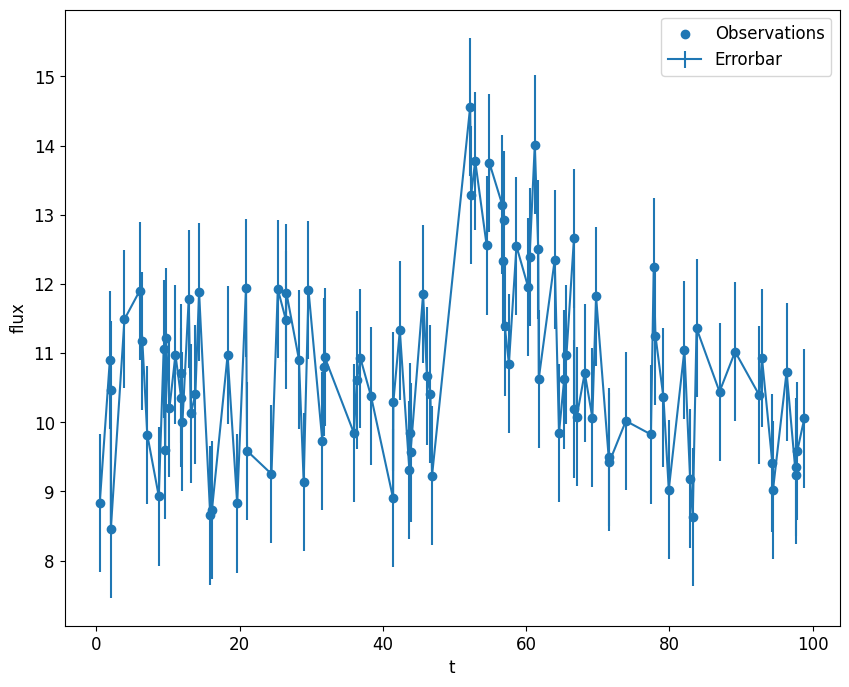

In [17]:
#Unpacking and visualizing data
#t = data[:, 0]
#flux = data[:, 1]
#flux_err = data[:, 2]

#Way faster unpacking!!
t, flux, flux_err = data.T

#Plotting with errors
plt.scatter(t, flux, label='Observations')
plt.errorbar(t, flux, yerr=flux_err, label='Errorbar')
plt.xlabel('t')
plt.ylabel('flux')
plt.legend()
plt.show()

In [18]:
#Function modeling Signal: Noise + Exponential decay
def burst_model(parameters, t):

    b, t_0, A, alpha = parameters.T

    return np.where(t<t_0, b, b + A * np.exp(-alpha * (t - t_0)))

#Function modeling Signal: Gaussian
def gauss_model(parameters, t):

    b, t_0, A, sigma = parameters.T

    return b + A * np.exp(((t - t_0) ** 2)/(2 * sigma ** 2))

In [20]:
def loglike(theta, data, model):
    t, flux, flux_err = data.T

    #Computing theoretical flux
    flux_th = model(theta, t)
    
    #Gaussian Log-Likelihood -> Distance from theoretical value
    logL = -0.5 * np.sum(((flux - flux_th)**2 / (flux_err)**2))

    return logL


def priors(theta, model):
    #Priors boundaries
    t0min, t0max = 0, 100
    Amin, Amax = 0, 50
    bmin, bmax = 0, 50
    alphamin, alphamax = np.exp(-5), np.exp(5)
    sigmamin, sigmamax = np.exp(-2), np.exp(2)

    #Accessing indexes, copying input array
    prior = np.array(theta)

    prior[0] = stats.uniform(loc=Amin, scale=Amax-Amin).ppf(theta[0])
    prior[1] = stats.uniform(loc=bmin, scale=bmax-bmin).ppf(theta[1])
    prior[2] = stats.uniform(loc=t0min, scale=t0max-t0min).ppf(theta[2])


    #Prior on last parameter is dependent on model selection
    if str(model) == 'burst_model':
        prior[3] = stats.loguniform.ppf(theta[3], alphamin, alphamax)

    elif str(model) == 'gauss_model':
        prior[3] = stats.loguniform.ppf(theta[3], sigmamin, sigmamax)

    return prior

In [31]:
#Burst model
ndim = 4
sampler = dynesty.NestedSampler(loglike, priors, ndim, logl_args=[data, burst_model], ptform_args=[burst_model], nlive=50)
sampler.run_nested()
result = sampler.results

889it [00:23, 37.38it/s, +50 | bound: 152 | nc: 1 | ncall: 13098 | eff(%):  7.197 | loglstar:   -inf < -48.770 <    inf | logz: -63.505 +/-  0.511 | dlogz:  0.001 >  0.059]


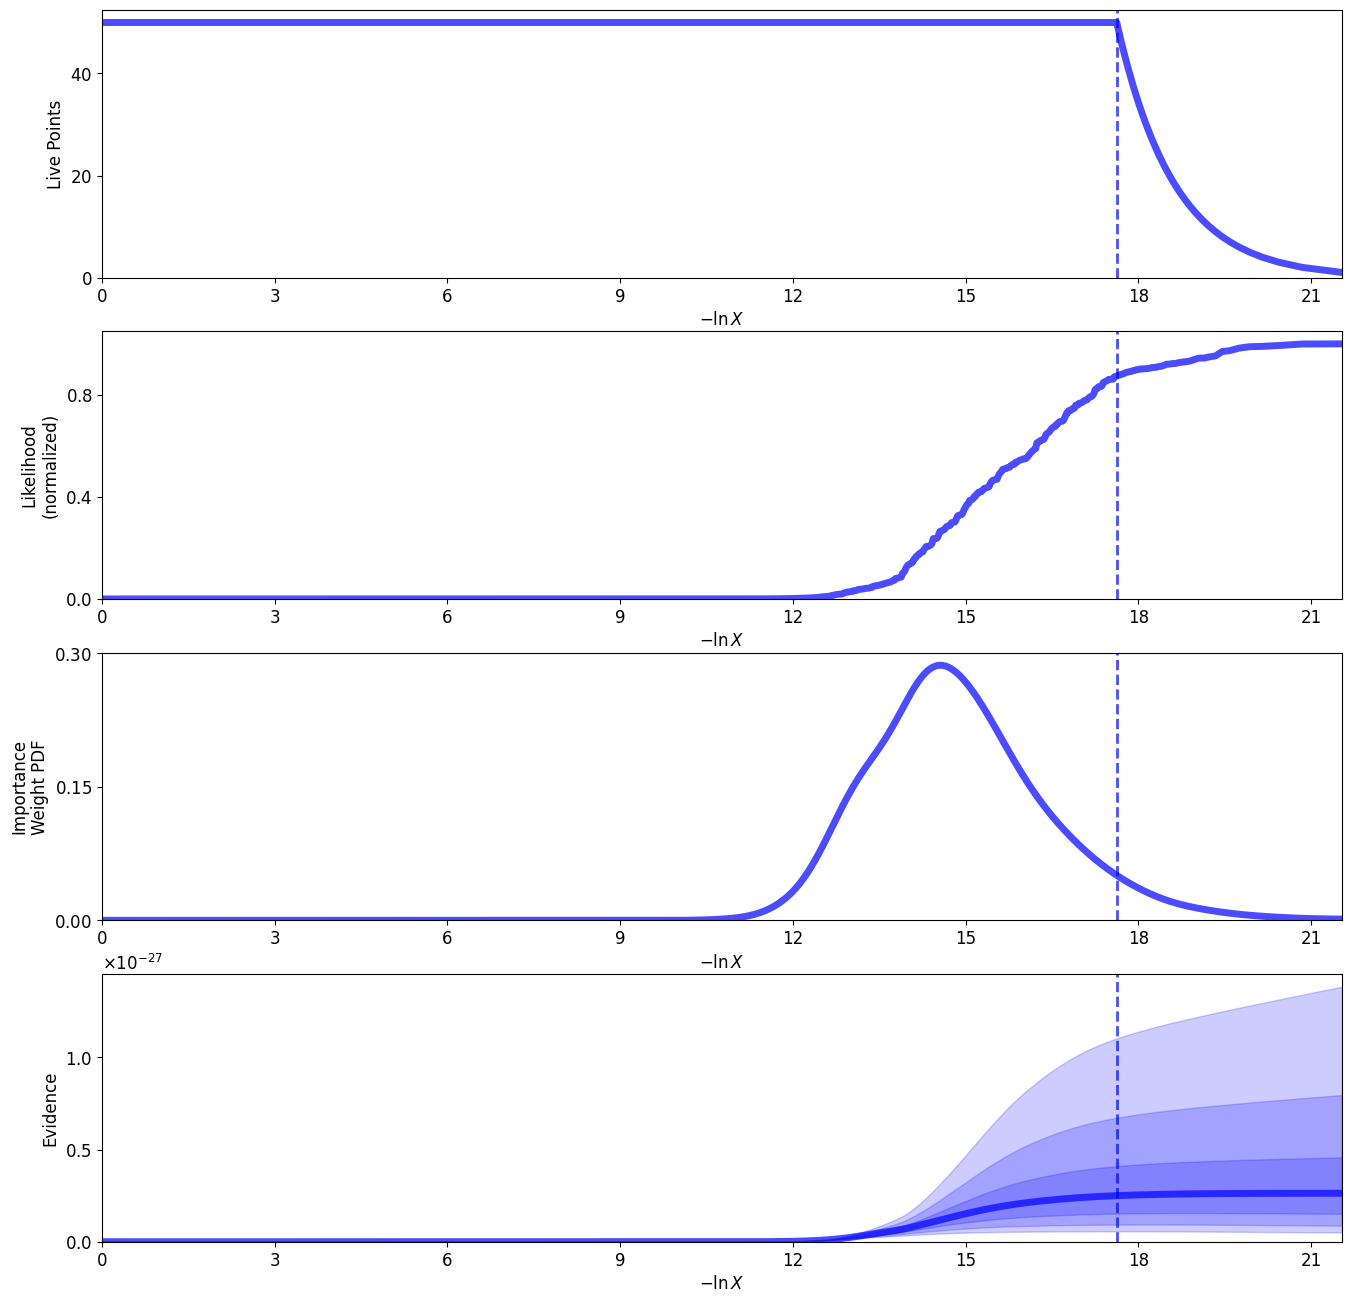

In [32]:
#Summary plots
s_fig, s_axes = dyplot.runplot(result)

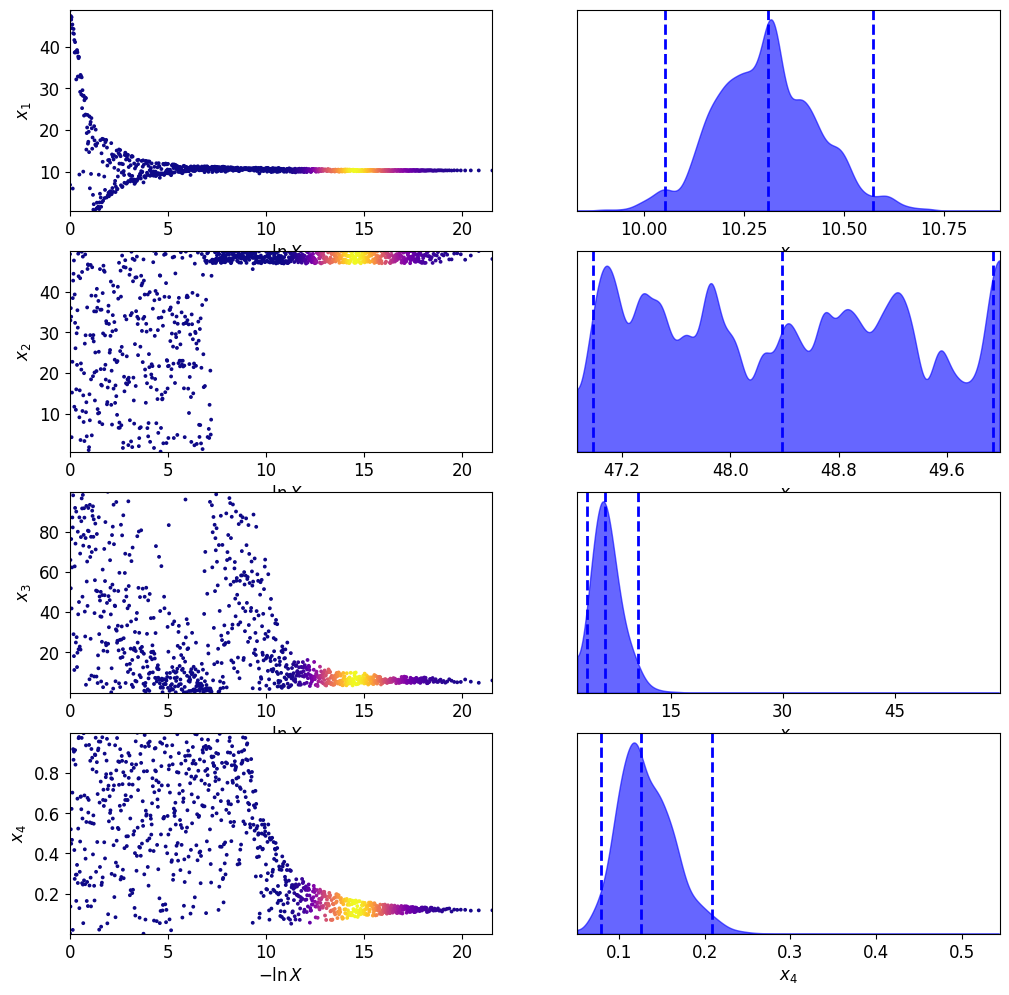

In [33]:
#Trace plots
t_fig, t_axes = dyplot.traceplot(result)

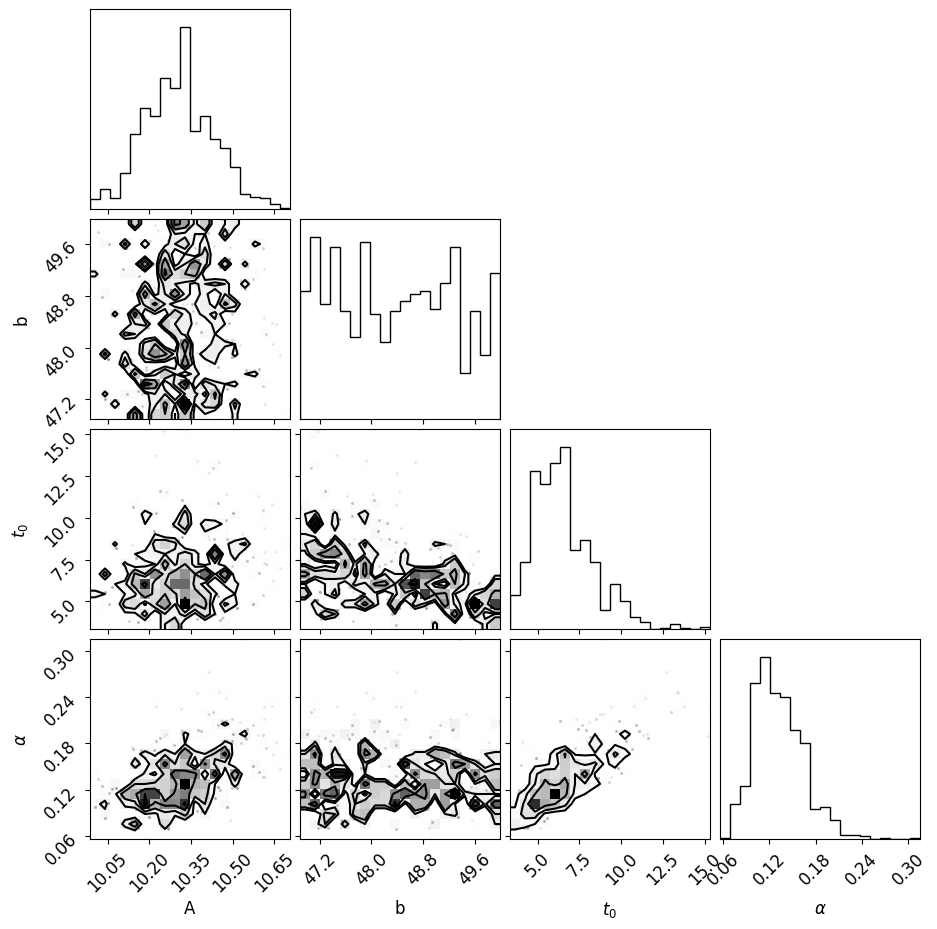

In [38]:

samples = result.samples  # samples
weights = np.exp(result.logwt - result.logz[-1])  # normalized weights

labels = ["A","b",r"$t_{0}$",r"$\alpha$"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels);